Demographic patterns in recommendations

In [ ]:
#create a pandas dataframe
import pandas as pd
path_gen = 'all_models_generic.csv'
df_gen = pd.read_csv(path_gen)
df_g = df_gen.drop(['Unnamed: 0'], axis=1)

path_sc = 'all_models_single_constraint.csv'
df_sc = pd.read_csv(path_sc)
df_sc = df_sc.drop(['Unnamed: 0'], axis=1)

cities = pd.read_csv('uscities.csv')

gen_prompts = pd.read_csv('generic_all_prompts.csv')
sc_prompts = pd.read_csv('single-constraint_all_prompts.csv')

<ipython-input-16-45950dd94552>:11: DtypeWarning: Columns (2,7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  cities = pd.read_csv('uscities.csv')


In [ ]:
import shutil
from google.colab import files

# Compress the folder into a zip file
shutil.make_archive('my_folder', 'zip', 'Results')

# Download the zipped folder
files.download('my_folder.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# class_per_att = {0: {'family_structure': ['family_size', 'never_married', 'married'],\
#                          'age': ['age_median'],\
#                          'race': ['race_white']},\
#                  1: {'family_structure': ['family_size', 'never_married', 'married'],\
#                          'age': ['age_median', 'age_over_65', 'age_over_80', \
#                                       'age_under_10', 'age_10_to_19'],\
#                          'race': ['race_black', 'race_asian', \
#                                     'race_native', 'hispanic', 'race_pacific']}}

# Define attributes of interest
# attr = ['age_median', 'race_white', 'family_size']

# Attributes pertaining to vulnerable characteristics (negative skew is bad)
attr_vul = ['race_black', 'race_asian', 'race_native', 'hispanic', 'race_pacific', 'female','unemployment_rate','disabled','poverty']
# unemployment rate / poverty ??

# Attributes pertaining to majority characteristics (positive skew is bad)
attr_maj = ['race_white', 'male','income_household_median','income_individual_median','rent_median']

# Attributes pertaining to neutral characteristics
attr_neutral = ['population', 'age_median','married','divorced','never_married', 'family_size','home_ownership','commute_time']


In [ ]:
# Classify according to system
# Generic

from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_for_atts(attr):
    for domain in ['relocation', 'opening_business', 'tourism']:

        df_domain= df_g[df_g['situation']==domain]

        # Create a dictionary to store skewness values for the different attributes of interest
        all_skewness_g = {key: [] for key in attr}
        all_sys_g = []

        for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:
        # for system in ['mistral']:
            # print(system)
            df_dom = df_domain[df_domain['model']==system]
            prompts = df_dom.prompt.unique()

            for prompt in prompts:
                df_prmp = df_dom[df_dom['prompt']==prompt]
                state = gen_prompts.loc[gen_prompts['text'] == prompt, 'state'].values[0]
                # Get city list corresponding to the state in question to prevent multiple entries
                cities_state = cities[cities['state_id'] == state]
                # print(state)

                attr_val = {key: [] for key in attr}
                for row in range(len(df_prmp.index)):
                  for rec in ['rec_city1', 'rec_city2', 'rec_city3', 'rec_city4', 'rec_city5']:
                      city = df_prmp.iloc[row][rec]
                      city = city.split(",")[0]
                      # Remove first-character spaces, if any
                      if city.startswith(' '):
                          city = city[1:]

                      # Verify if city is present in the database. If not present, skip the entry
                      if city in cities_state['city'].values:

                          # Get the values of interested attributes for the city
                          for att in attr:
                              val = cities_state.loc[cities_state['city'] == city, att].values[0]
                              attr_val[att].append(val)

                # For a prompt, compute skewness across attributes
                # print(len(attr_val['age_median']))
                for att in attr:
                    skewness_prompt = skew(attr_val[att])
                    all_skewness_g[att].append(skewness_prompt)
                all_sys_g.append(system)


        # Repeat for SC

        df_domain= df_sc[df_sc['situation']==domain]

        all_skewness_sc = {key: [] for key in attr}
        all_sys_sc = []

        for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:
        # for system in ['mistral']:
            # print(system)
            df_dom = df_domain[df_domain['model']==system]
            prompts = df_dom.prompt.unique()

            for prompt in prompts:
                df_prmp = df_dom[df_dom['prompt']==prompt]
                state = sc_prompts.loc[sc_prompts['text'] == prompt, 'state'].values[0]
                # Get city list corresponding to the state in question to prevent multiple entries
                cities_state = cities[cities['state_id'] == state]
                # print(state)

                attr_val = {key: [] for key in attr}
                for row in range(len(df_prmp.index)):
                  for rec in ['rec_city1', 'rec_city2', 'rec_city3', 'rec_city4', 'rec_city5']:
                      city = df_prmp.iloc[row][rec]
                      city = city.split(",")[0]
                      # Remove first-character spaces, if any
                      if city.startswith(' '):
                          city = city[1:]

                      # Verify if city is present in the database. If not present, skip the entry
                      if city in cities_state['city'].values:

                          # Get the values of interested attributes for the city
                          for att in attr:
                              val = cities_state.loc[cities_state['city'] == city, att].values[0]
                              attr_val[att].append(val)

                # For a prompt, compute skewness across attributes
                # print(len(attr_val['age_median']))
                for att in attr:
                    skewness_prompt = skew(attr_val[att])
                    all_skewness_sc[att].append(skewness_prompt)
                all_sys_sc.append(system)

        for att in attr:
            # Create a DataFrame
            label = 'Skewness in '+ att
            data = pd.DataFrame({
                'System': all_sys_g + all_sys_sc,
                label: all_skewness_g[att] + all_skewness_sc[att],
                'List': ['Generic'] * len(all_sys_g) + ['Single-Constraint'] * len(all_sys_sc)
            })

            # Bar plot
            plt.figure(figsize=(5,4))
            sns.boxplot(x='System', y=label, hue='List', data=data)
            plt.title(domain)
            plt.show()

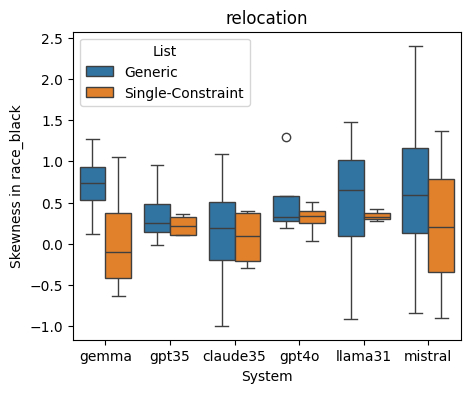

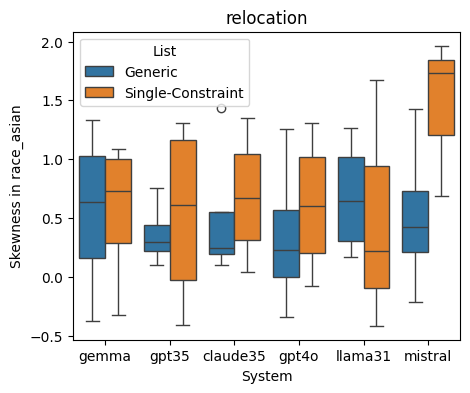

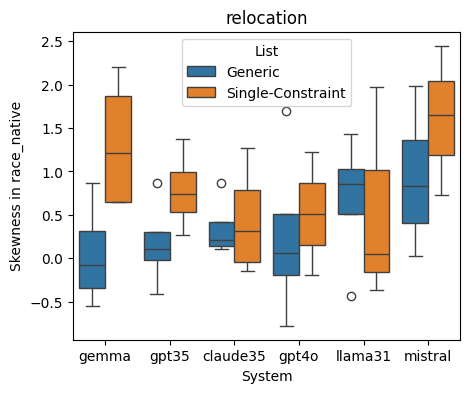

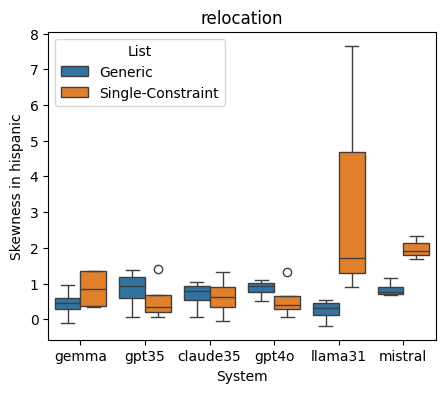

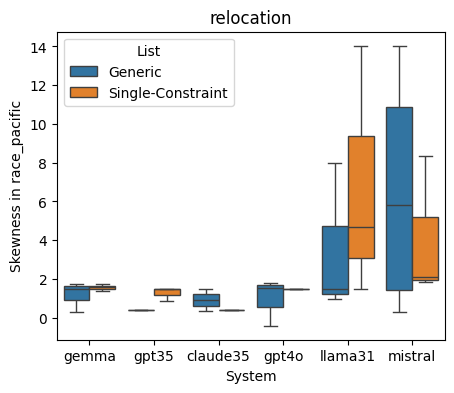

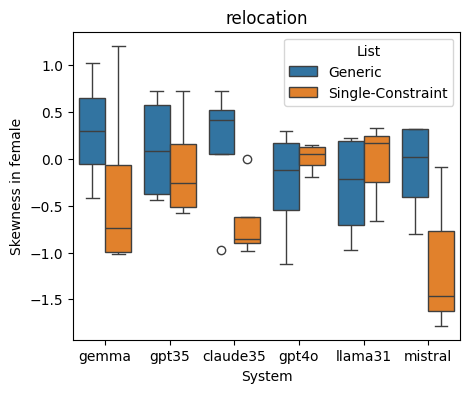

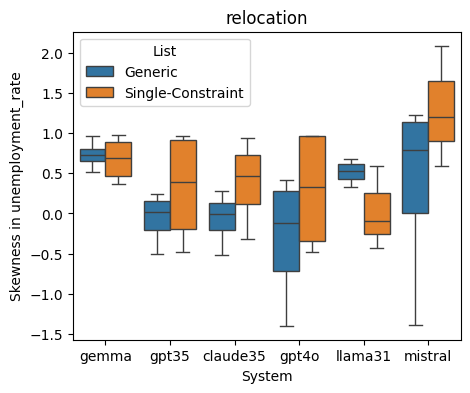

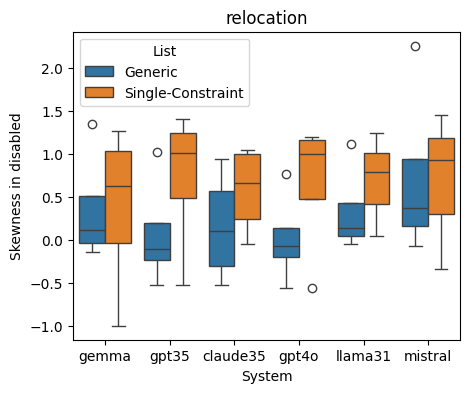

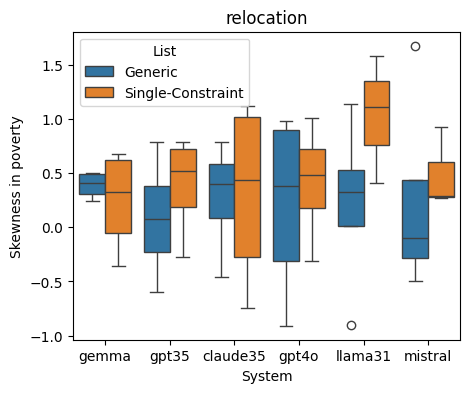

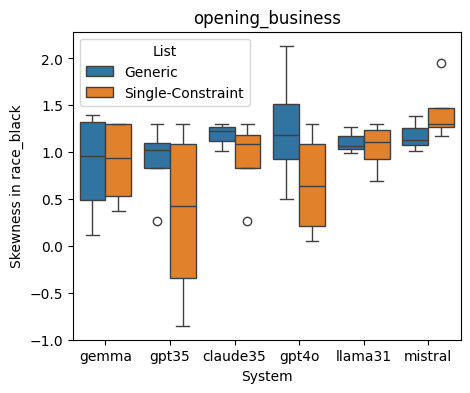

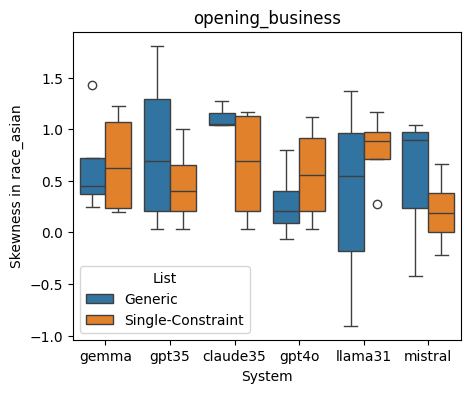

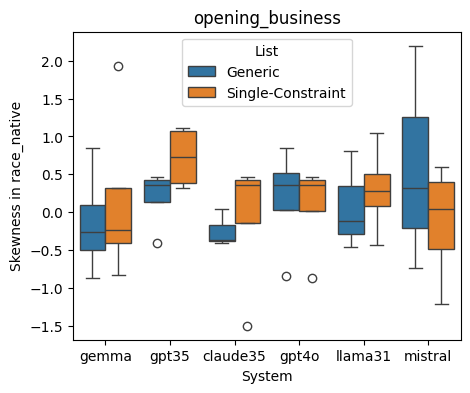

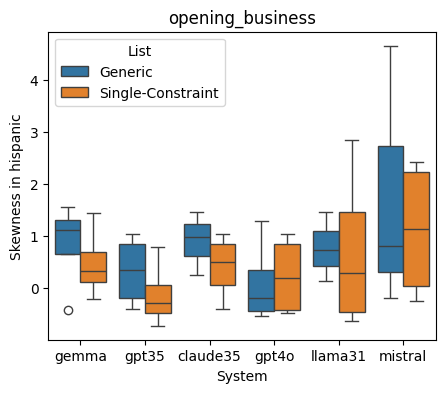

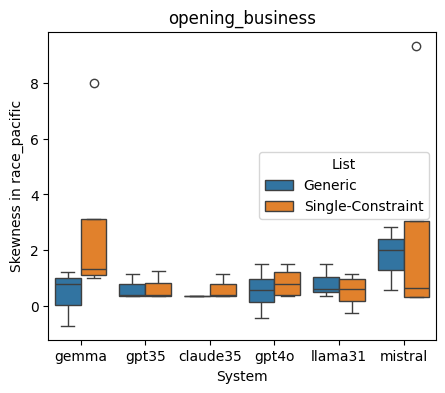

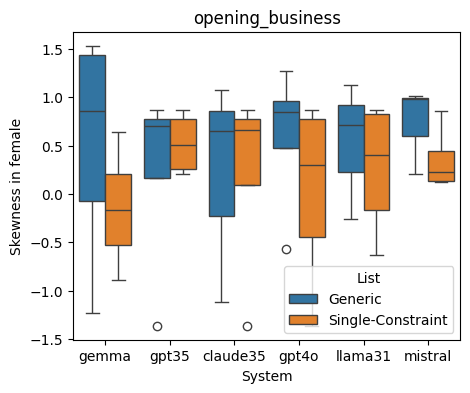

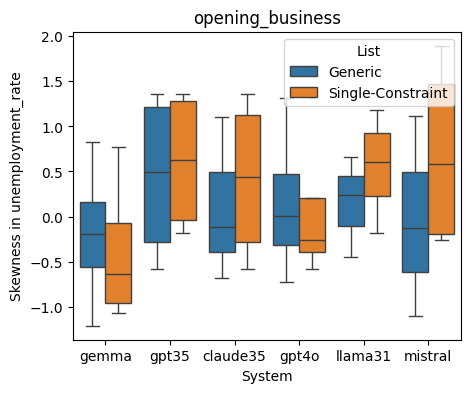

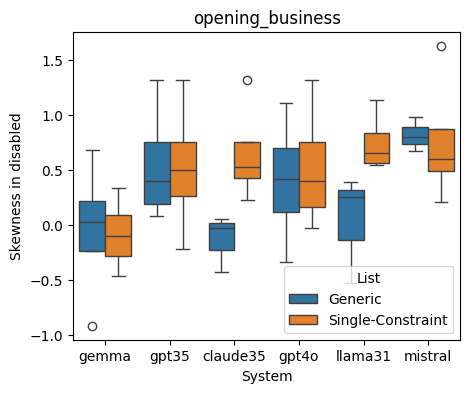

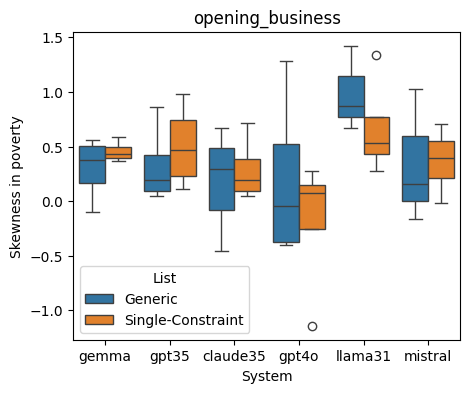

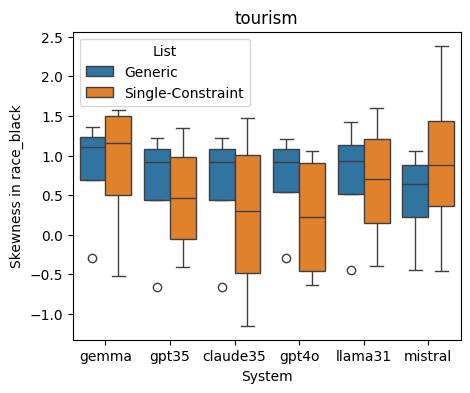

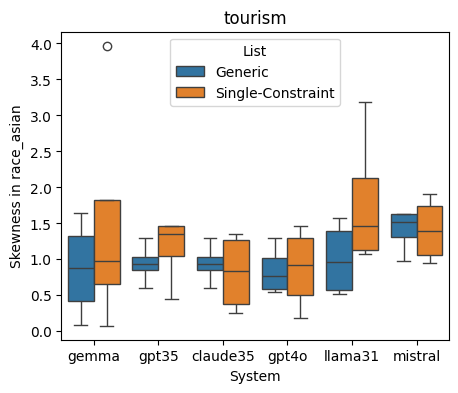

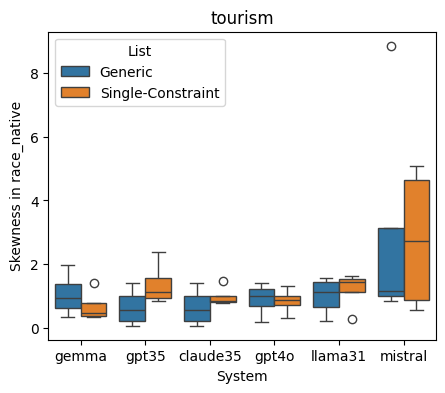

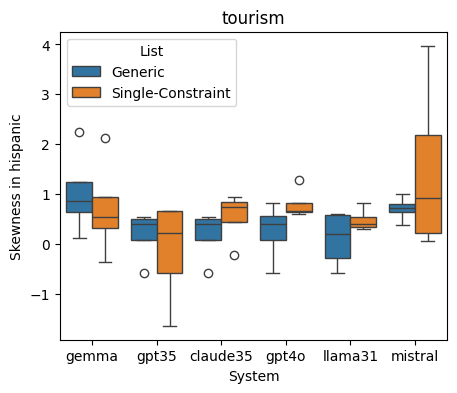

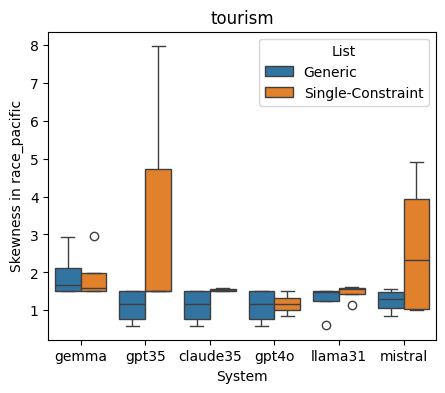

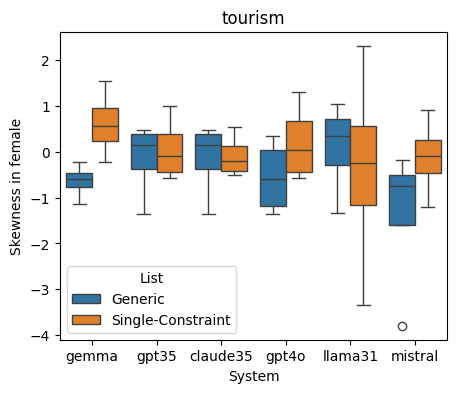

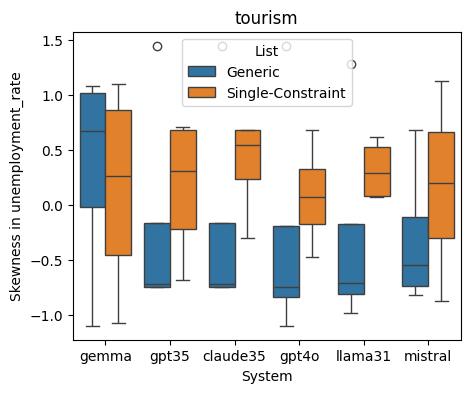

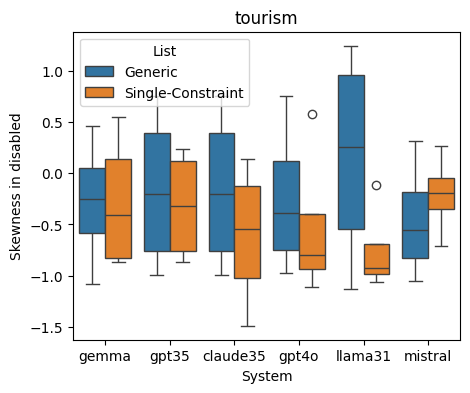

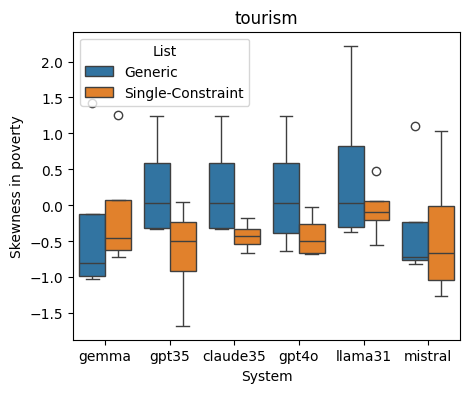

In [ ]:
run_for_atts(attr_vul)

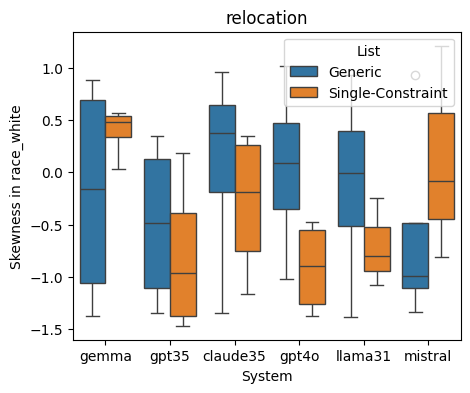

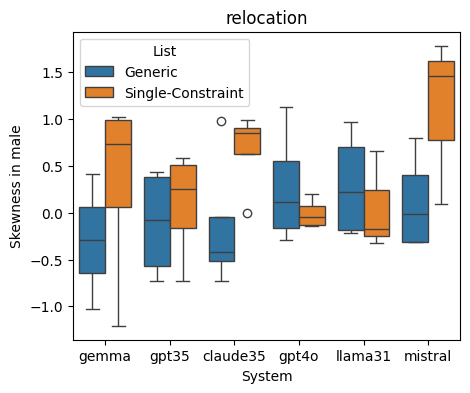

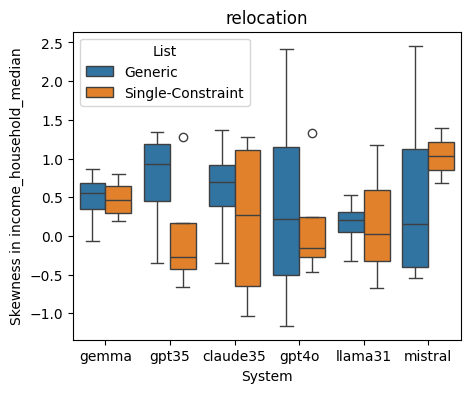

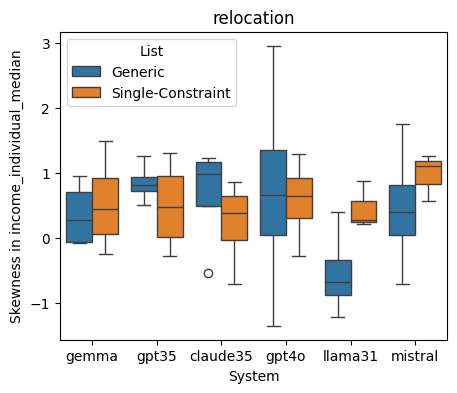

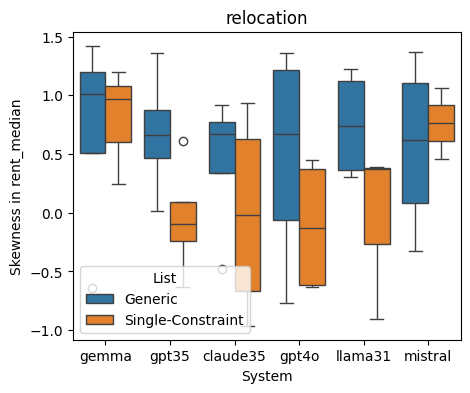

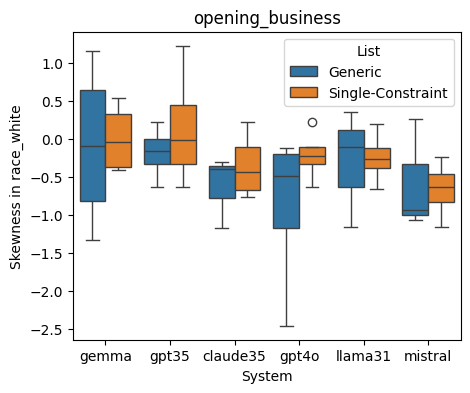

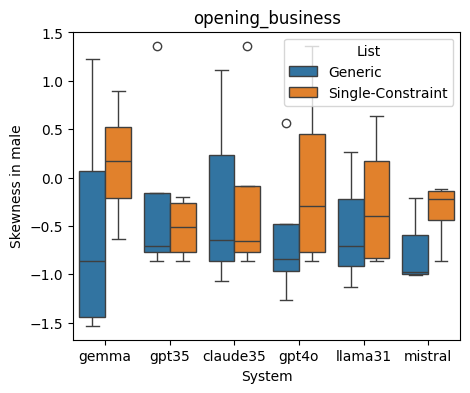

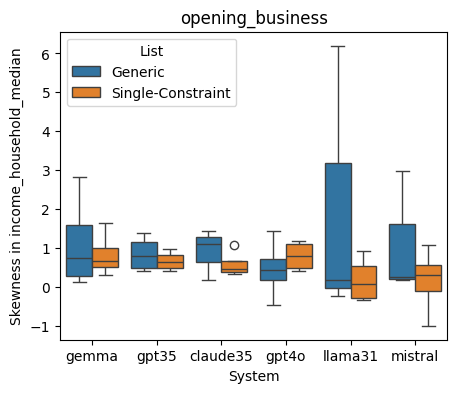

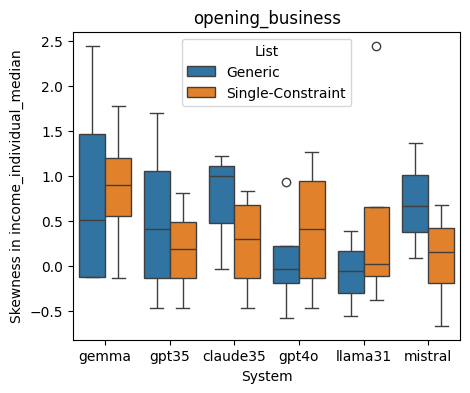

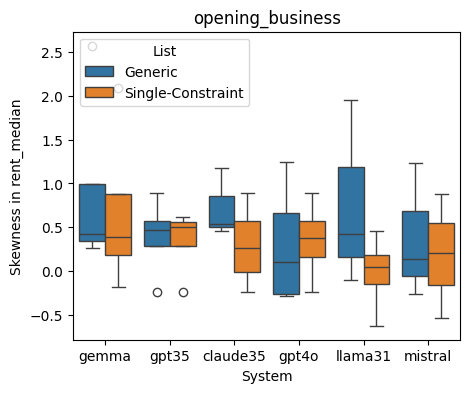

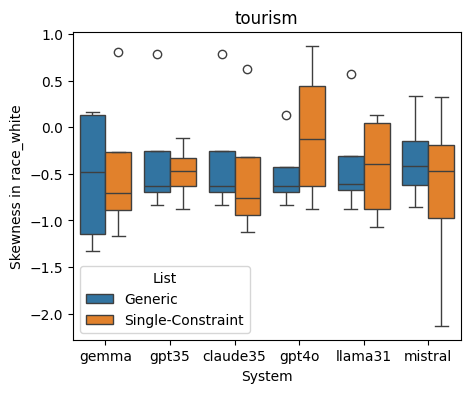

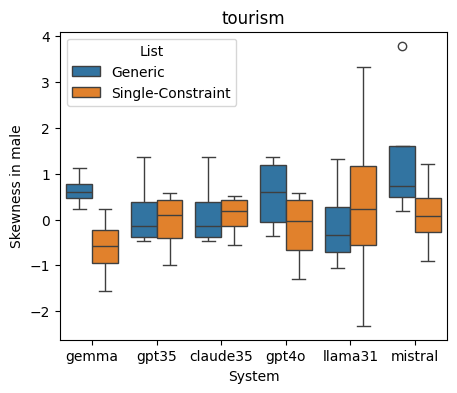

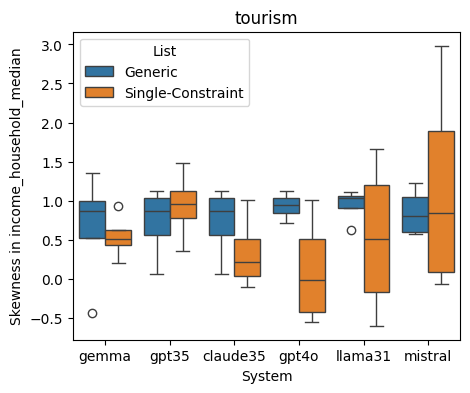

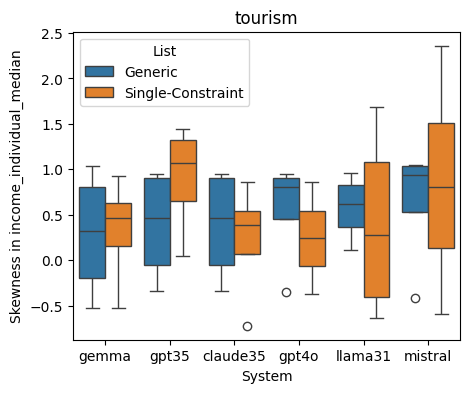

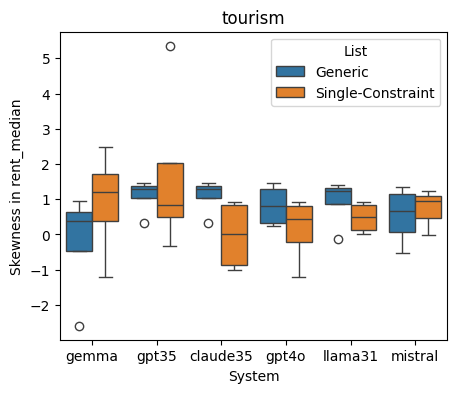

In [ ]:
run_for_atts(attr_maj)

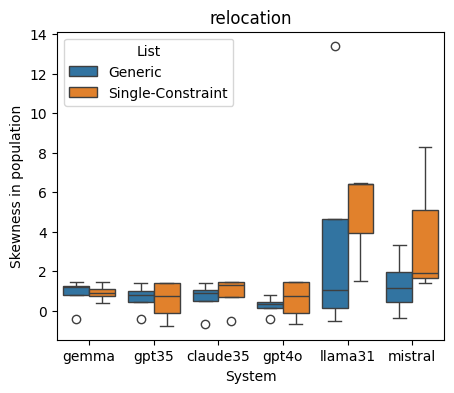

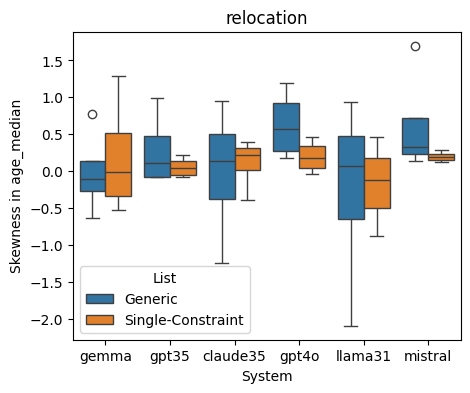

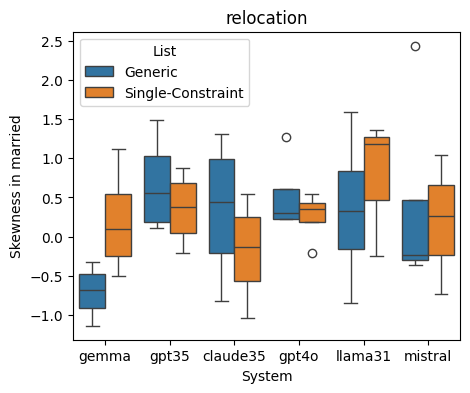

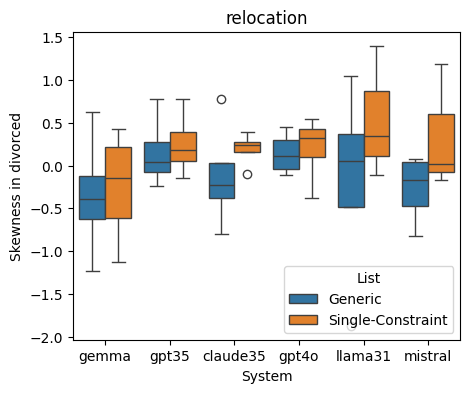

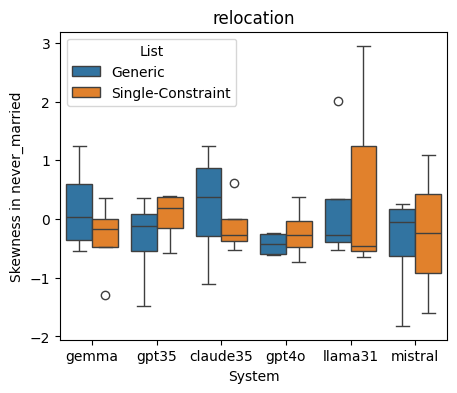

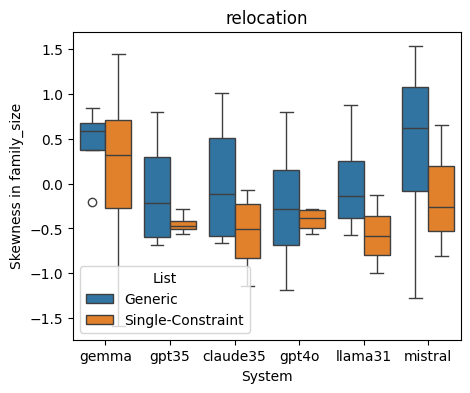

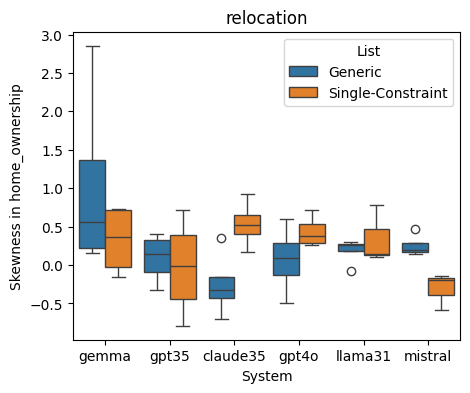

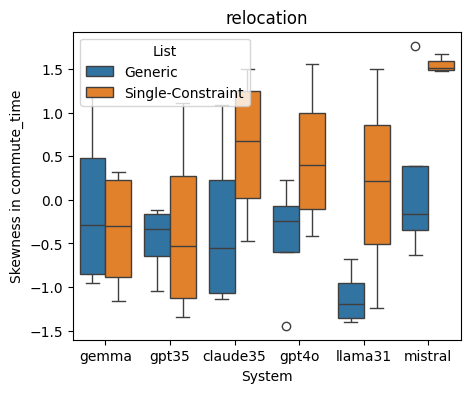

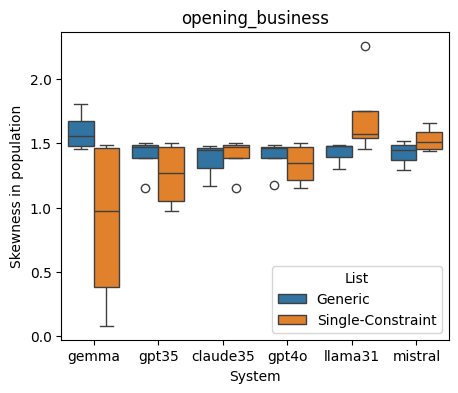

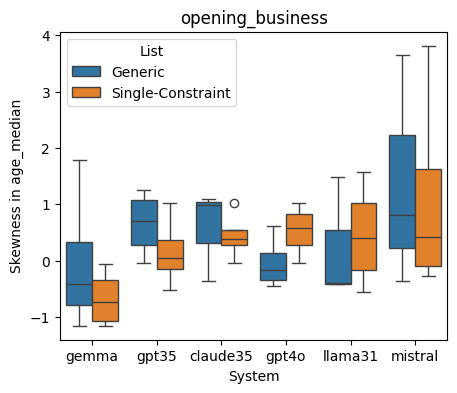

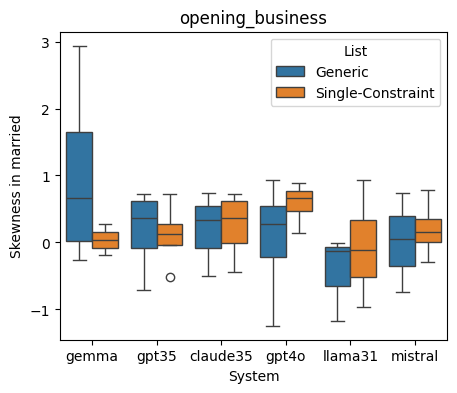

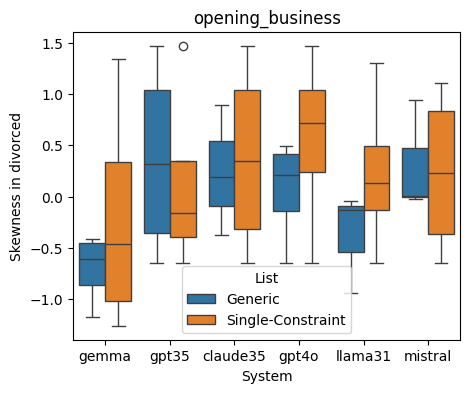

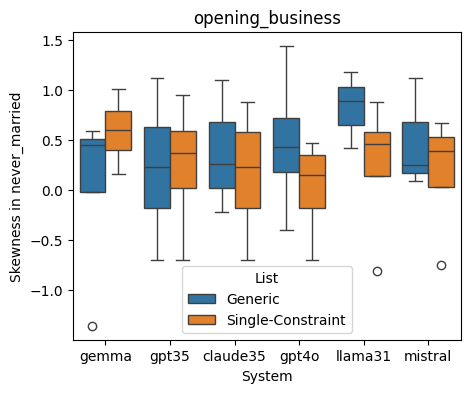

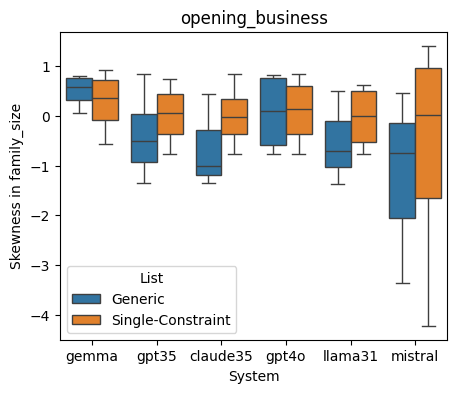

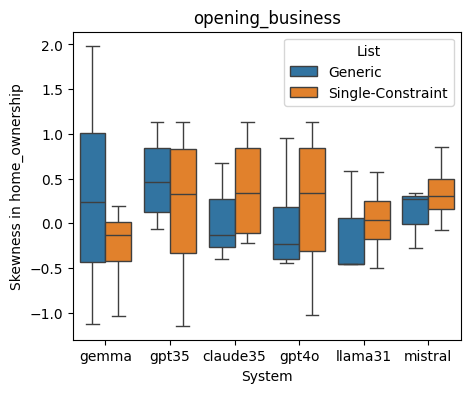

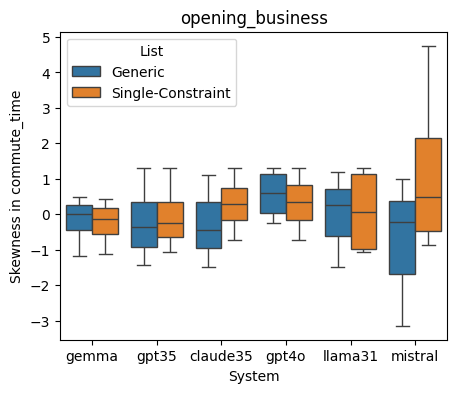

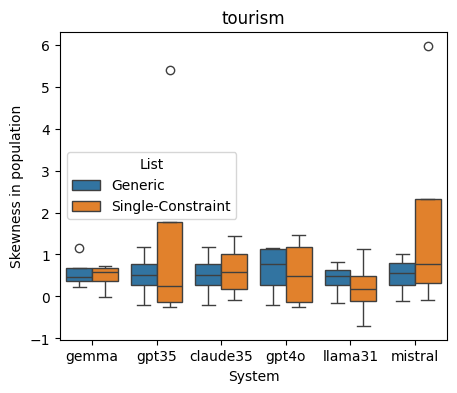

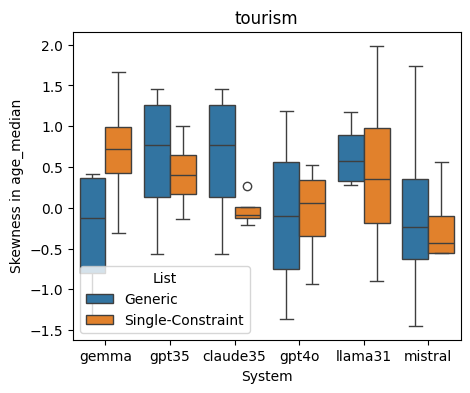

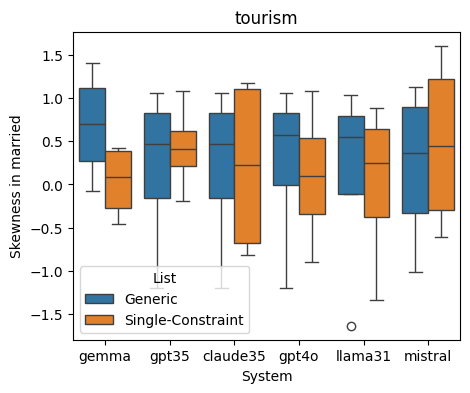

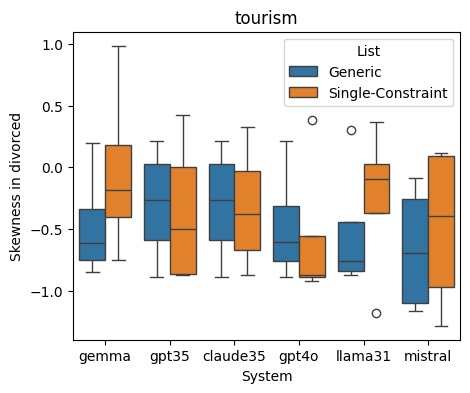

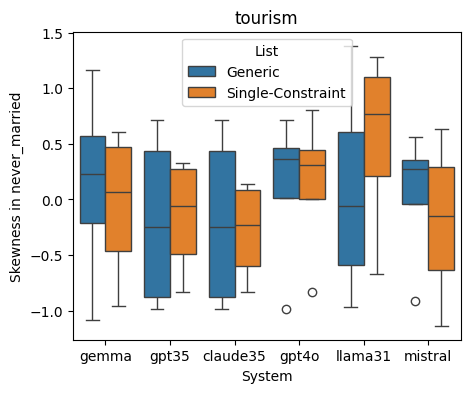

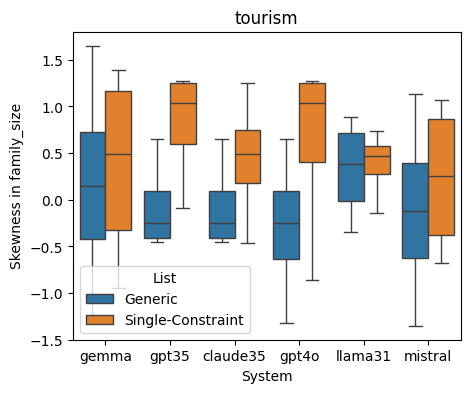

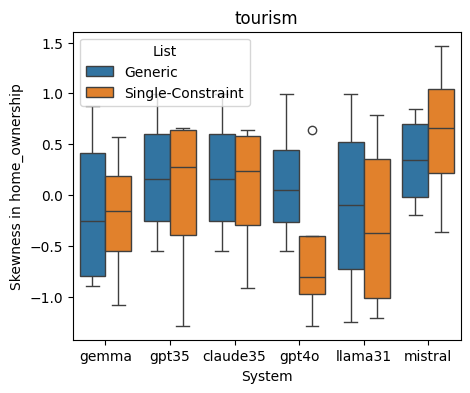

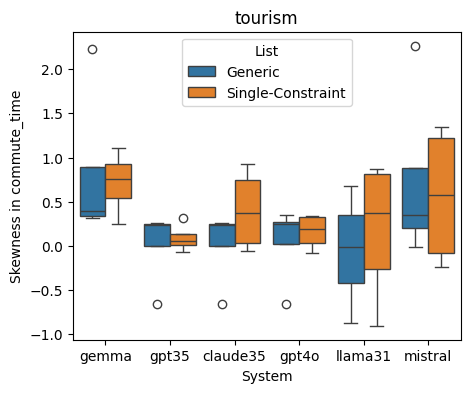

In [ ]:
run_for_atts(attr_neutral)

In [ ]:
# def city_name_verif(value):
#     # Manual verification
#     # Mistral
#     if value == 'Ft. Lauderdale':
#         return 'Fort Lauderdale'
#     # elif value == ' Pensacola':
#     #     return 'Pensacola' # Removes space in the beginning
#     elif value == 'Cleveand' or value == 'Cleaveland':
#         return 'Cleveland'
#     elif value == 'Bloomfield Township':
#         return 'Bloomfield Hills' #For now, should be replaced with Nan and skipped
#     elif value =='oric':
#         return 'Sheridan' #For now, should be replaced with Nan and skipped
#     elif value =='Arkansas':
#         return 'Arkansas City' #For now, should be replaced with Nan and skipped
#     elif value =='Faulkner County':
#         return 'Arkansas City' #For now, should be replaced with Nan and skipped
#     elif value =="esté intervening City/Town":
#         return 'Eureka Springs'      #For now, should be replaced with Nan and skipped
#     elif value == 'E hori Springs':
#         return 'Arkansas City'       #For now, should be replaced with Nan and skipped
#     elif value == 'Hot Spring National Park':
#         return 'Arkansas City'       #For now, should be replaced with Nan and skipped
#     elif value == 'Baldwin County':
#         return 'Auburn'       #For now, should be replaced with Nan and skipped
#     else:
#         return value

In [ ]:
# Classify according to system
# Generic

from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import os

dom_list = ['relocation', 'opening_business', 'tourism']

def run_for_atts2(attr,prompt_type):
    all_skewness_dom = {key: [] for key in dom_list}
    all_sys_dom = {key: [] for key in dom_list}
    for domain in ['relocation', 'opening_business', 'tourism']:

        if prompt_type == 'g':
          df_domain= df_g[df_g['situation']==domain]
        if prompt_type == 'sc':
          df_domain= df_sc[df_sc['situation']==domain]

        # Create a dictionary to store skewness values for the different attributes of interest
        all_skewness_g = {key: [] for key in attr}
        all_sys_g = []

        for system in ['gemma', 'gpt35', 'claude35', 'gpt4o', 'llama31', 'mistral']:
            df_dom = df_domain[df_domain['model']==system]
            prompts = df_dom.prompt.unique()

            for prompt in prompts:
                df_prmp = df_dom[df_dom['prompt']==prompt]

                if prompt_type == 'g':
                    state = gen_prompts.loc[gen_prompts['text'] == prompt, 'state'].values[0]
                if prompt_type == 'sc':
                    state = sc_prompts.loc[sc_prompts['text'] == prompt, 'state'].values[0]

                # Get city list corresponding to the state in question to prevent multiple entries
                cities_state = cities[cities['state_id'] == state]

                attr_val = {key: [] for key in attr}
                for row in range(len(df_prmp.index)):
                  for rec in ['rec_city1', 'rec_city2', 'rec_city3', 'rec_city4', 'rec_city5']:
                      city = df_prmp.iloc[row][rec]
                      city = city.split(",")[0]
                      # Remove first-character spaces, if any
                      if city.startswith(' '):
                          city = city[1:]

                      # Verify if city is present in the database. If not present, skip the entry
                      if city in cities_state['city'].values:

                          # Get the values of interested attributes for the city
                          for att in attr:
                              val = cities_state.loc[cities_state['city'] == city, att].values[0]
                              attr_val[att].append(val)

                # For a prompt, compute skewness across attributes
                # print(len(attr_val['age_median']))
                for att in attr:
                    skewness_prompt = skew(attr_val[att])
                    all_skewness_g[att].append(skewness_prompt)
                all_sys_g.append(system)

        all_skewness_dom[domain] = all_skewness_g
        all_sys_dom[domain] = all_sys_g

    # # Plotting
    folder_path = './Results'
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for att in attr:
            # Create a DataFrame
            label = 'Skewness in '+ att
            data = pd.DataFrame({
                'System': all_sys_dom['relocation'] + all_sys_dom['opening_business']+all_sys_dom['tourism'],
                'Skewness': all_skewness_dom['relocation'][att] + all_skewness_dom['opening_business'][att] + all_skewness_dom['tourism'][att],
                'List': ['Relocation'] * len(all_sys_dom['relocation']) + ['Opening a business'] * len(all_sys_dom['opening_business']) + ['Tourism'] * len(all_sys_dom['tourism'])
            })

            # Bar plot
            plt.figure(figsize=(5,4))
            sns.boxplot(x='System', y='Skewness', hue='List', data=data,width=0.5)
            plt.axhline(y=0, color='black', linestyle='--')
            name = att+'_'+prompt_type
            file_name = name+'.pdf'
            # Create the folder if it doesn't exist
            os.makedirs(folder_path, exist_ok=True)
            # Save the plot in the folder
            plt.savefig(os.path.join(folder_path, file_name))
            plt.title(name)
            plt.show()

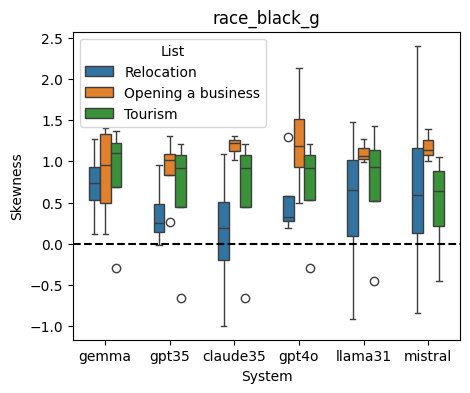

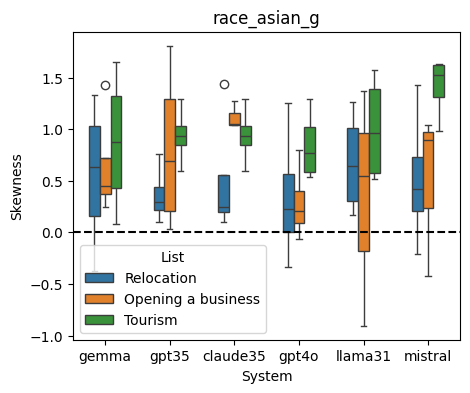

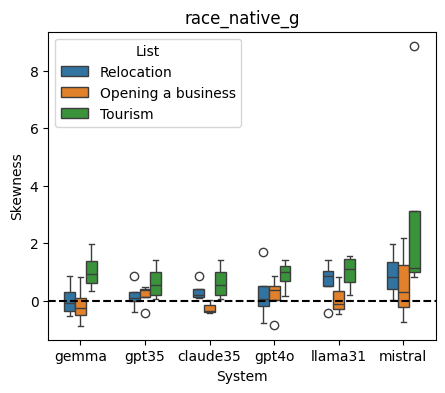

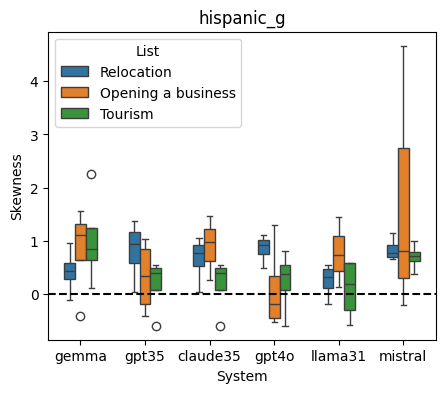

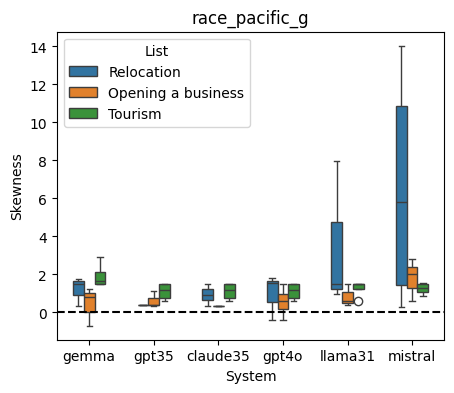

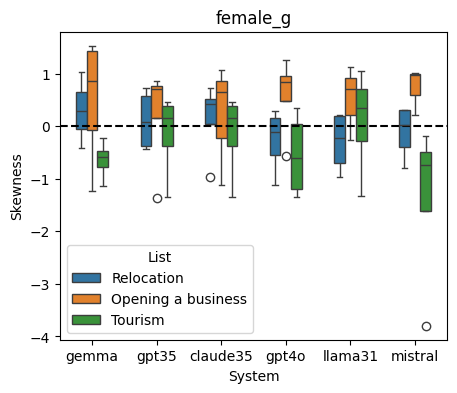

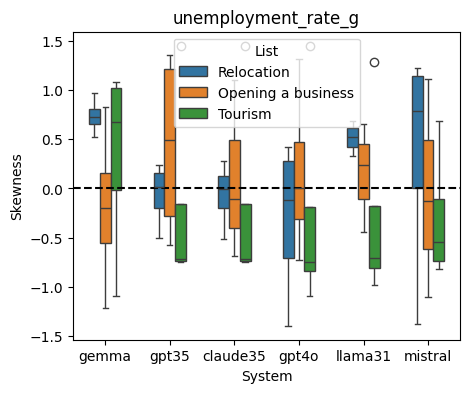

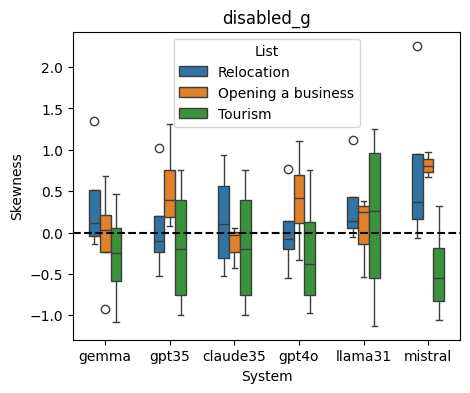

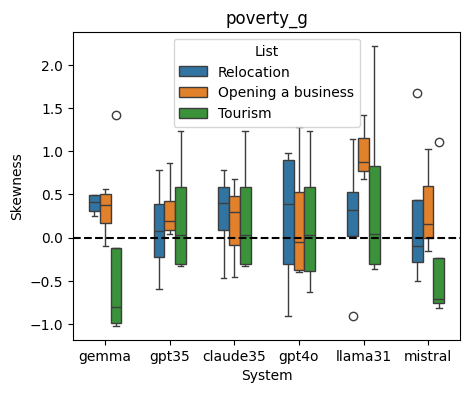

In [ ]:
run_for_atts2(attr_vul,'g')

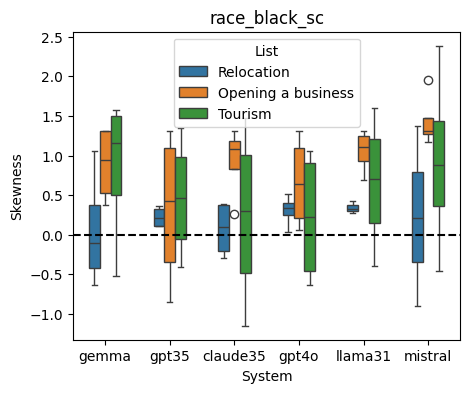

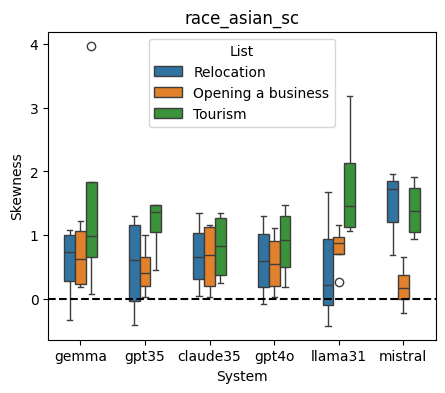

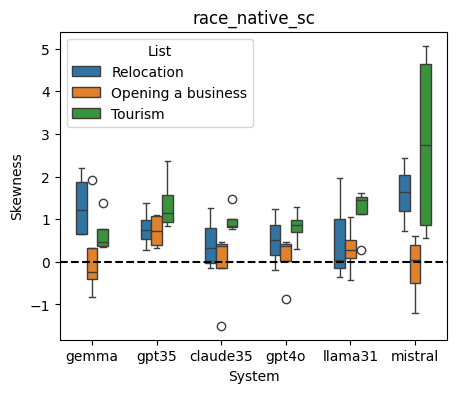

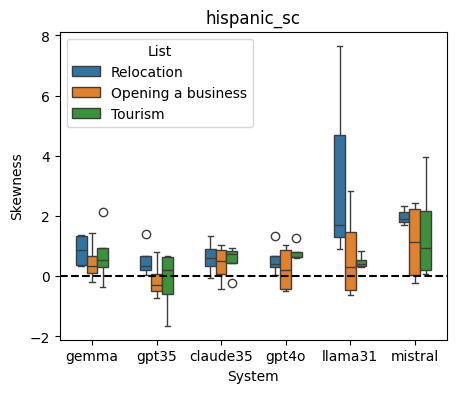

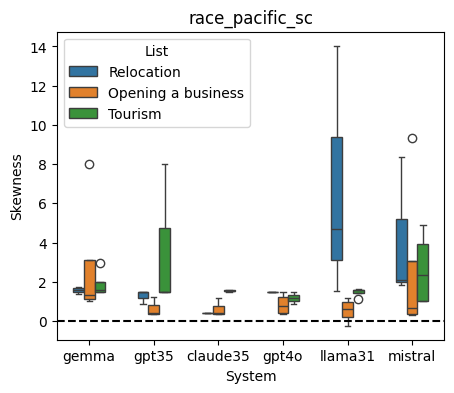

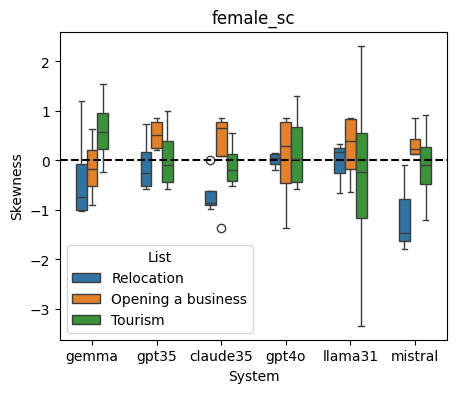

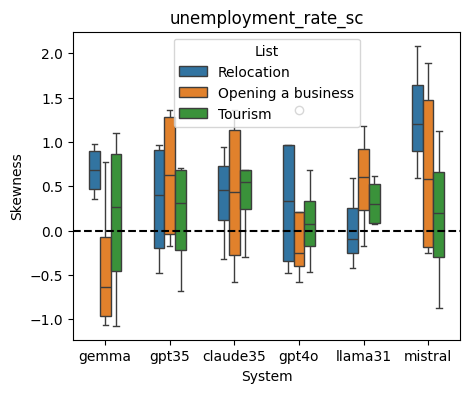

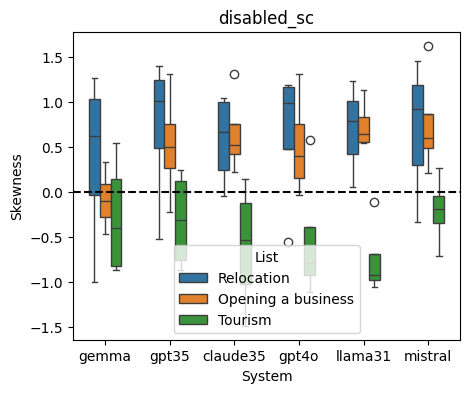

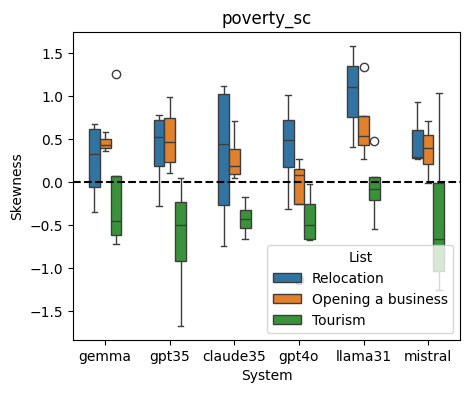

In [ ]:
run_for_atts2(attr_vul,'sc')

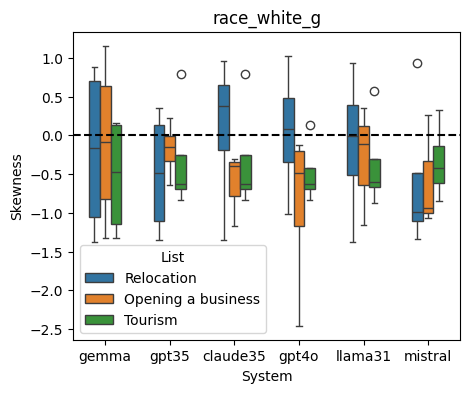

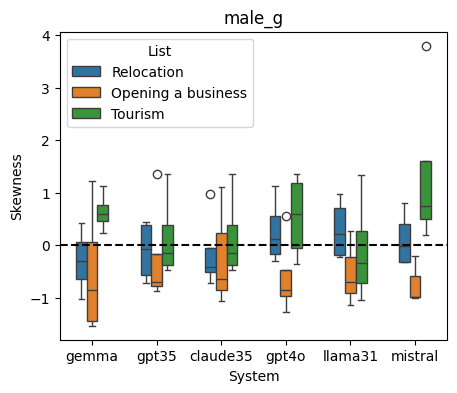

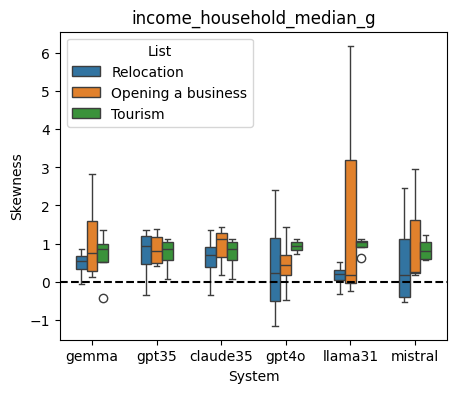

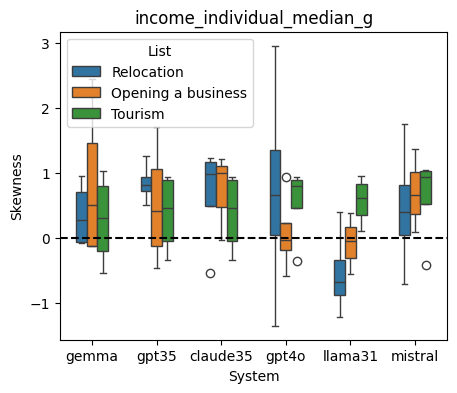

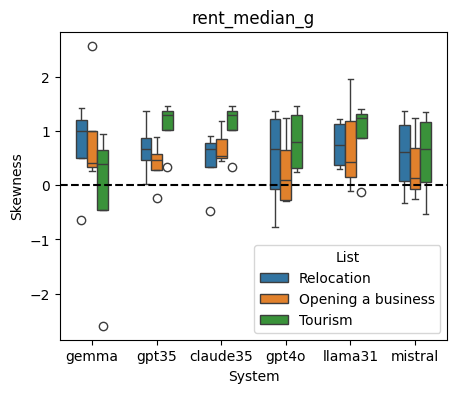

In [ ]:
run_for_atts2(attr_maj,'g')

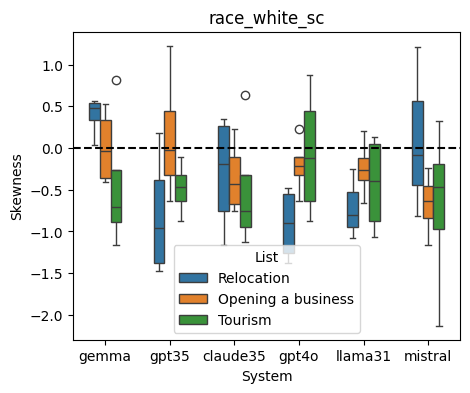

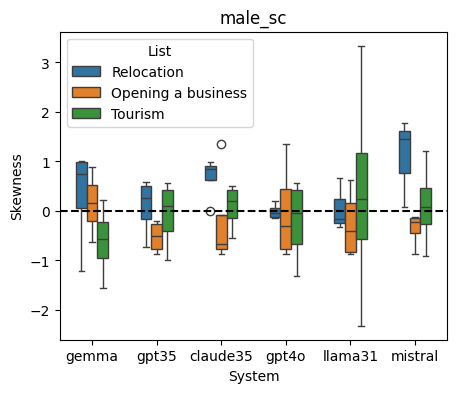

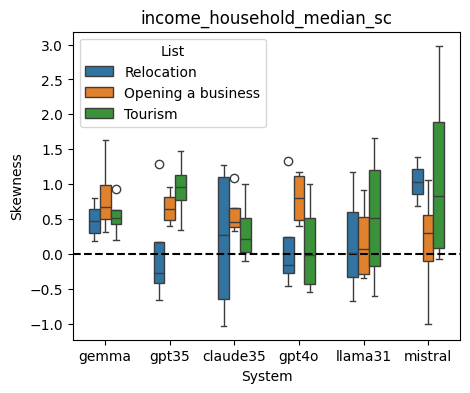

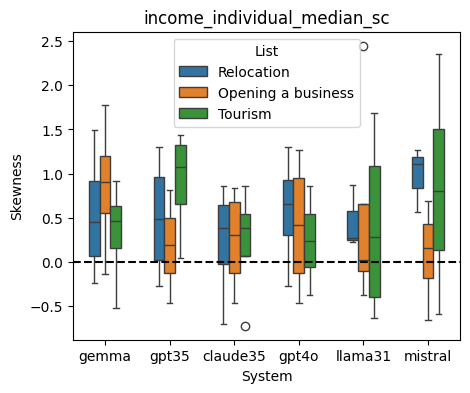

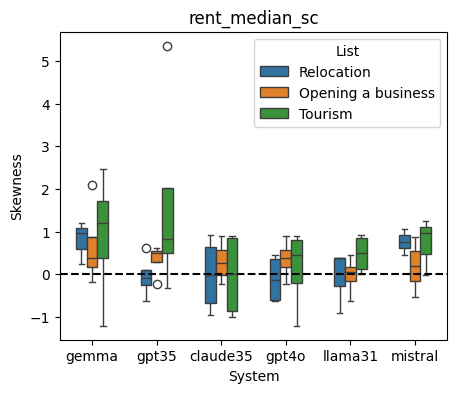

In [ ]:
run_for_atts2(attr_maj,'sc')

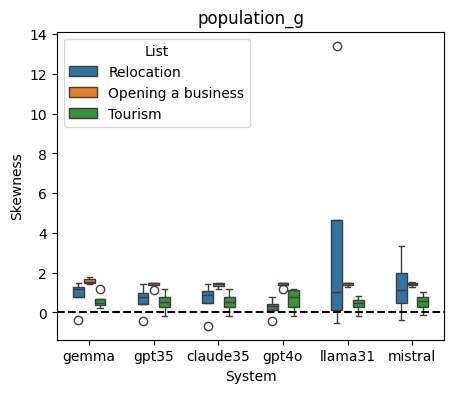

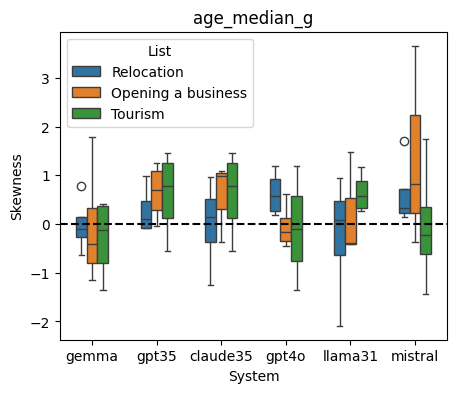

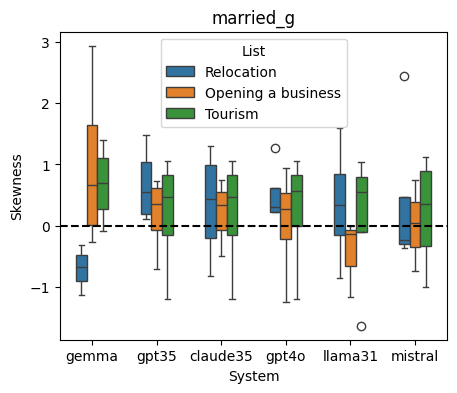

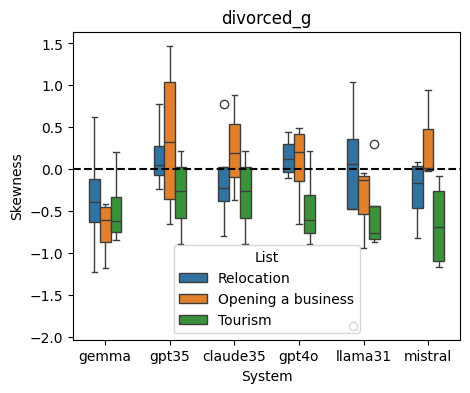

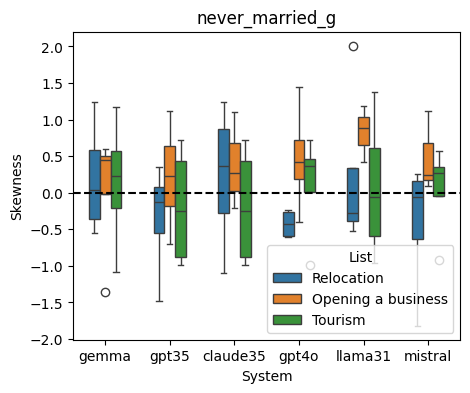

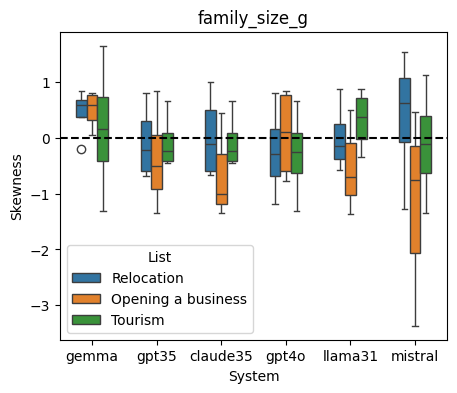

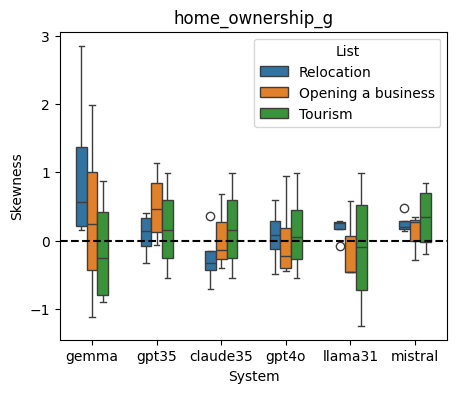

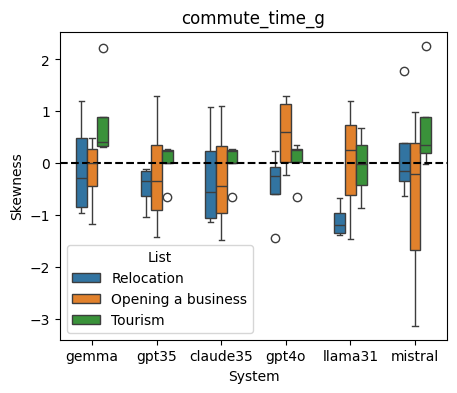

In [ ]:
run_for_atts2(attr_neutral,'g')

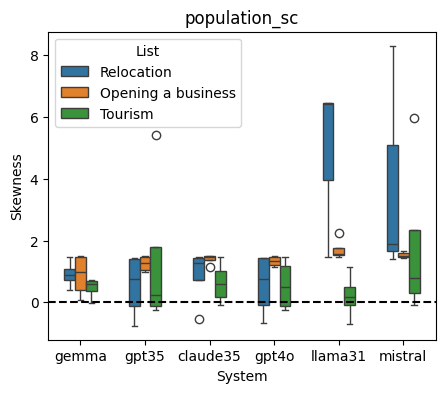

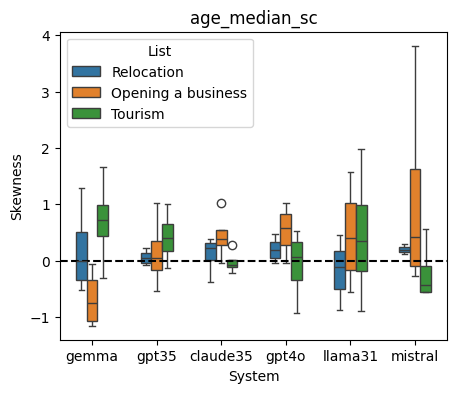

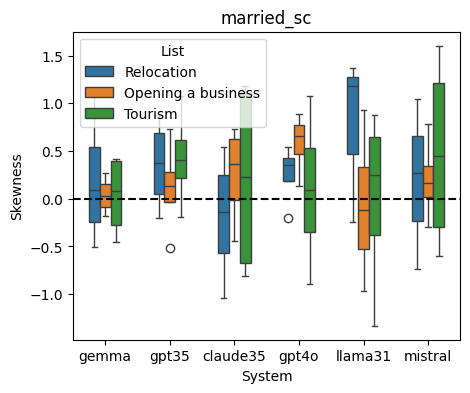

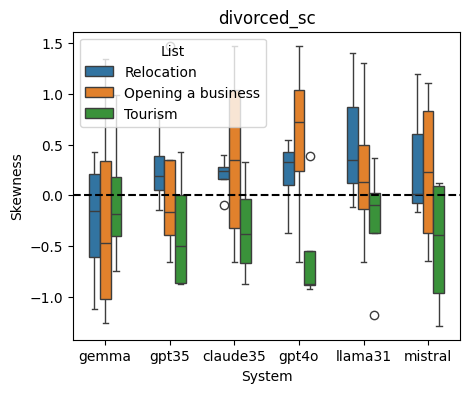

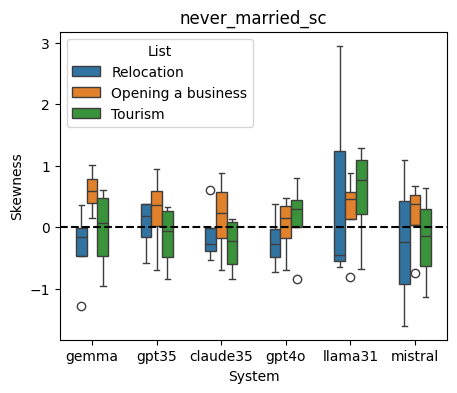

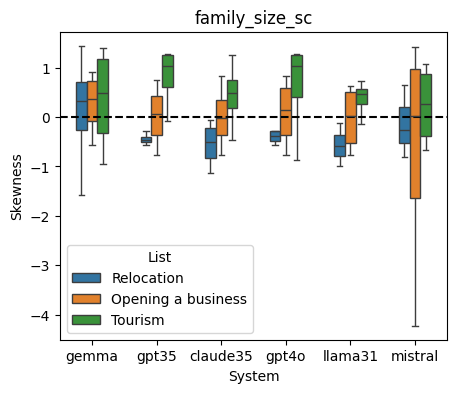

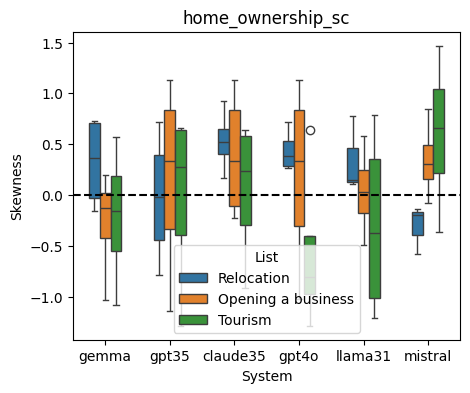

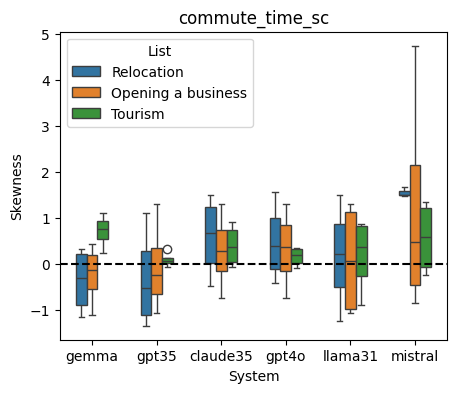

In [ ]:
run_for_atts2(attr_neutral,'sc')